In [1]:
from simulate import HawkesProcess
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats 

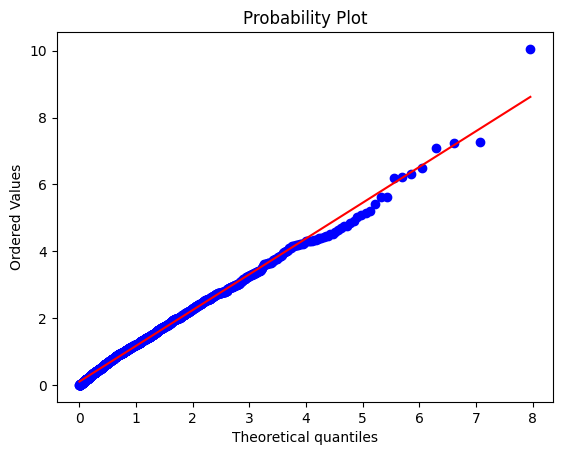

In [4]:
mu, alpha, beta = 1, 1, 1.5
hwk = HawkesProcess(mu, alpha, beta)
T = 1000
events = hwk.simulate(T)

hwk.plot_QQ(events)